### Imports

In [1]:
from src.digit_functions import loadDigits
from Models import PixelDensityModel

import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{torch.__version__}")
print(f"{np.__version__}")
print(f"{mpl.__version__}")
print(f"{device}")

2.0.0+cpu
1.24.2
3.7.1
cpu


# Pixel Density Based Sudoku Solver Model

### Load Feature Transformed Training Digits

In [2]:
SRC = "./data/digits/transformed/pixelDensity/"

transformedDigits = loadDigits(SRC)

(+) Reading data from .npy file...
(+) Digit loading finished


### Training

In [3]:
X_TRAIN_TENSOR = torch.tensor(transformedDigits[0][0], dtype=torch.float32)
Y_TRAIN_TENSOR = torch.tensor(transformedDigits[0][1] - 1, dtype=torch.long)
print(X_TRAIN_TENSOR.shape)
print(Y_TRAIN_TENSOR.shape)
X_TEST_TENSOR = torch.tensor(transformedDigits[1][0], dtype=torch.float32)
Y_TEST_TENSOR = torch.tensor(transformedDigits[1][1] - 1, dtype=torch.long)
print(X_TEST_TENSOR.shape)
print(Y_TEST_TENSOR.shape)

torch.Size([1496250, 80])
torch.Size([1496250])
torch.Size([78750, 80])
torch.Size([78750])


In [4]:
BATCH_SIZE = 256
tensorDataset = torch.utils.data.TensorDataset(X_TRAIN_TENSOR, Y_TRAIN_TENSOR)
dataloader = torch.utils.data.DataLoader(tensorDataset, BATCH_SIZE, shuffle=True)

In [5]:
model = PixelDensityModel()
model = model.to(device)
lossfn = torch.nn.CrossEntropyLoss()

In [6]:
LEARNING_RATE = 0.01
BETAS = (0.9, 0.99)
EPS = 1e-5
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE, BETAS, EPS)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.8, total_iters=8)

In [7]:
EPOCHS = 10

trainLosses = []
testLosses = []
trainAccuracies = []
testAccuracies = []

for epoch in range(EPOCHS):

    model.train()

    for x_batch, y_batch in dataloader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        _Y = model(x_batch)
        loss = lossfn(_Y, y_batch)

        loss.backward()

        optimizer.step()

    model.eval()

    _Y = model(X_TRAIN_TENSOR)
    trainLoss = lossfn(_Y, Y_TRAIN_TENSOR).item()
    trainLosses.append(trainLoss)
    trainAccuracy = accuracy_score(Y_TRAIN_TENSOR.detach().cpu().numpy(), _Y.detach().cpu().argmax(dim=1).numpy())
    trainAccuracies.append(trainAccuracy)

    _Y = model(X_TEST_TENSOR)
    testLoss = lossfn(_Y, Y_TEST_TENSOR).item()
    testLosses.append(testLoss)
    testAccuracy = accuracy_score(Y_TEST_TENSOR.detach().cpu().numpy(), _Y.detach().cpu().argmax(dim=1).numpy())
    testAccuracies.append(testAccuracy)

    scheduler.step()

    if epoch % 3 == 0:
        print(f"Epoch: {epoch}:")
        print(f"\tLosses: {trainLosses[-1]} - {testLosses[-1]}")
        print(f"\tAccuracies: {trainAccuracies[-1]} - {testAccuracies[-1]}")
        print(f"\tCurrent learning rate: {optimizer.param_groups[0]['lr']}")

Epoch: 0:
	Losses: 0.03480133041739464 - 0.035491909831762314
	Accuracies: 0.9884865497076023 - 0.9884190476190476
	Current learning rate: 0.00975
Epoch: 3:
	Losses: 0.0031788477208465338 - 0.002600654261186719
	Accuracies: 0.9991097744360903 - 0.9992634920634921
	Current learning rate: 0.009
Epoch: 6:
	Losses: 0.002700387267395854 - 0.002618679776787758
	Accuracies: 0.9993624060150376 - 0.9992761904761904
	Current learning rate: 0.008249999999999999
Epoch: 9:
	Losses: 0.0005942894495092332 - 0.0005932352505624294
	Accuracies: 0.9998730158730159 - 0.9998730158730159
	Current learning rate: 0.007999999999999998


In [8]:
print(trainLosses)
print(testLosses)
print(trainAccuracies)
print(testAccuracies)

[0.03480133041739464, 0.015861131250858307, 0.006627772469073534, 0.0031788477208465338, 0.008175523020327091, 0.027489418163895607, 0.002700387267395854, 0.004567096009850502, 0.00016722983855288476, 0.0005942894495092332]
[0.035491909831762314, 0.01792343705892563, 0.007269972935318947, 0.002600654261186719, 0.009265166707336903, 0.026693325489759445, 0.002618679776787758, 0.005569692235440016, 0.0001281460135942325, 0.0005932352505624294]
[0.9884865497076023, 0.9957988304093567, 0.9979181286549708, 0.9991097744360903, 0.9981908103592314, 0.9954653299916458, 0.9993624060150376, 0.9989881370091896, 0.9999572263993317, 0.9998730158730159]
[0.9884190476190476, 0.9956571428571429, 0.9976, 0.9992634920634921, 0.9980571428571429, 0.9955809523809523, 0.9992761904761904, 0.9988190476190476, 0.9999746031746032, 0.9998730158730159]


Text(0.5, 1.0, 'Accuracies')

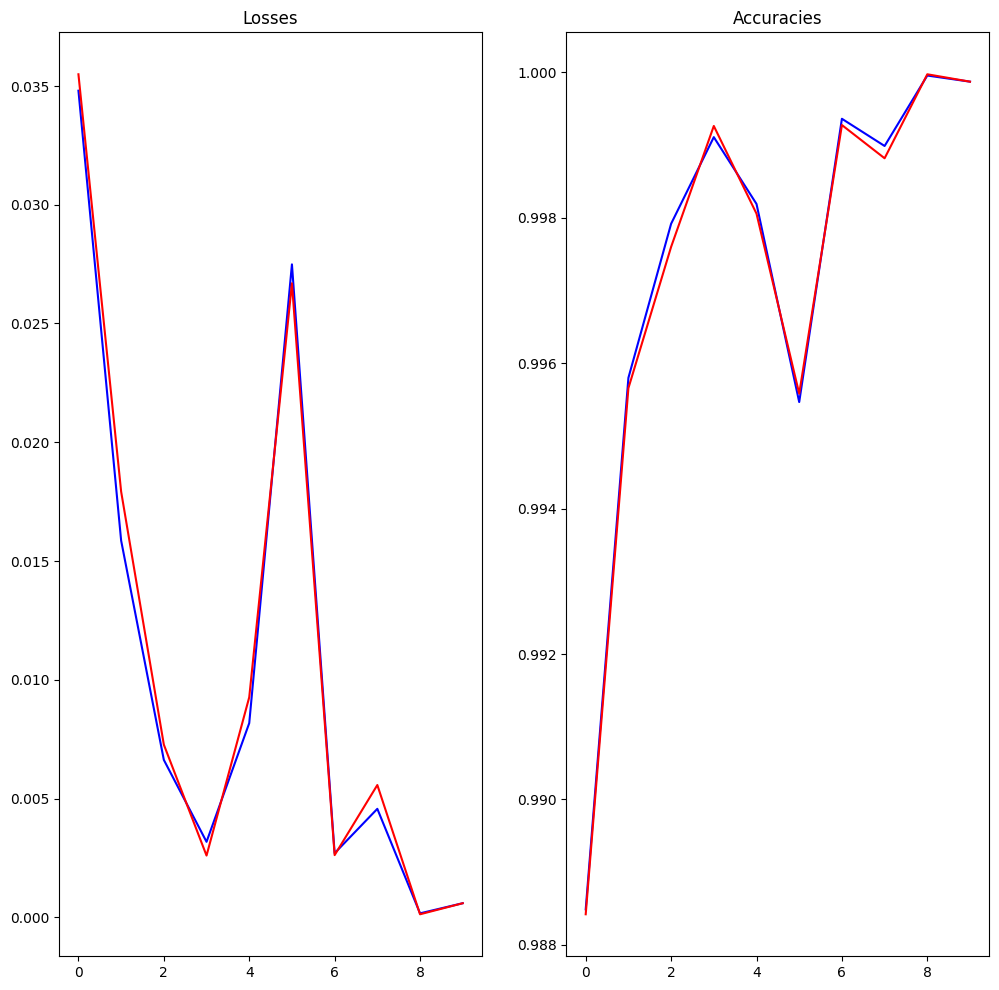

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()

axs[0].plot(np.arange(0, EPOCHS, 1), trainLosses, color="blue")
axs[0].plot(np.arange(0, EPOCHS, 1), testLosses, color="red")
axs[0].set_title("Losses")

axs[1].plot(np.arange(0, EPOCHS, 1), trainAccuracies, color="blue")
axs[1].plot(np.arange(0, EPOCHS, 1), testAccuracies, color="red")
axs[1].set_title("Accuracies")


In [10]:
MODEL_DST = "./data/models/"
MODEL_NAME = "pixelDensity.pth"

torch.save(model, MODEL_DST + MODEL_NAME)